In [6]:
# Compare the performance of KNN, Logistic Regression, Decision Trees, and Support Vector Machines on a marketing dataset for bank products over the telephone.

In [7]:
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv

from scipy.linalg import svd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import time

import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [9]:
df['campaign'].value_counts().sort_index().count()
# The data from 42 marketing campaigns were used to build the models.
# There were 56 campaigns but not all were used in the dataset.

np.int64(42)

In [10]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

target:
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [11]:
for col in df.columns:
    print(col, df[col].isna().sum())
# No columns are missing values but some contain 'unknown'

age 0
job 0
marital 0
education 0
default 0
housing 0
loan 0
contact 0
month 0
day_of_week 0
duration 0
campaign 0
pdays 0
previous 0
poutcome 0
emp.var.rate 0
cons.price.idx 0
cons.conf.idx 0
euribor3m 0
nr.employed 0
y 0


In [12]:
# Replace strings with numbers
df['education'] = df['education'].replace({'basic.4y':4, 'basic.6y':6, 'basic.9y':9, 'high.school':12, 'illiterate':0, 'professional.course':20, 'university.degree':16, 'unknown':-1}).astype('int8')
df['contact'] = df['contact'].replace({'telephone':0, 'cellular':1}).astype('int8')
df['month'] = df['month'].replace({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}).astype('int8')
df['day_of_week'] = df['day_of_week'].replace({'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}).astype('int8')
df['poutcome'] = df['poutcome'].replace({'failure':0, 'nonexistent':1, 'success':2}).astype('int8')
df['y'] = df['y'].replace({'no':0, 'yes':1}).astype('int8')

# Replace unknown education with mean education. (The mean education is 12 years.)
df_temp = df[df['education'] > -1]
unk = df_temp['education'].mean()
df['education'] = df['education'].replace({-1:unk}).astype('int8')
del df_temp

# One-hot encoding
df = pd.get_dummies(df, columns=['job', 'marital', 'default', 'housing', 'loan'], dtype='int8')

# Shrink size of integers when possible
df['age'] = df['age'].astype('int8')
df['duration'] = df['duration'].astype('int16')
df['campaign'] = df['campaign'].astype('int8')
df['pdays'] = df['pdays'].astype('int8')
df['previous'] = df['previous'].astype('int8')

In [13]:
# There are too many 'unknown' entries in the database to remove the columns or rows.
# Drop column name_unknown because the infomation is captured in the other having the value, 0.
# In other words, if both columns have the value 0, the actual value is unknown.
df.drop(['job_unknown', 'marital_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
df['education'].value_counts()

,count
education,
16,12168
12,11246
9,6045
20,5243
4,4176
6,2292
0,18


In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.head()

,age,education,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,...,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,56,4,0,5,1,261,1,-25,0,1,...,0,0,1,0,1,0,1,0,1,0
1,57,12,0,5,1,149,1,-25,0,1,...,0,0,1,0,0,0,1,0,1,0
2,37,12,0,5,1,226,1,-25,0,1,...,0,0,1,0,1,0,0,1,1,0
3,40,6,0,5,1,151,1,-25,0,1,...,0,0,1,0,1,0,1,0,1,0
4,56,12,0,5,1,307,1,-25,0,1,...,0,0,1,0,1,0,1,0,0,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41176 non-null  int8   
 1   education          41176 non-null  int8   
 2   contact            41176 non-null  int8   
 3   month              41176 non-null  int8   
 4   day_of_week        41176 non-null  int8   
 5   duration           41176 non-null  int16  
 6   campaign           41176 non-null  int8   
 7   pdays              41176 non-null  int8   
 8   previous           41176 non-null  int8   
 9   poutcome           41176 non-null  int8   
 10  emp.var.rate       41176 non-null  float64
 11  cons.price.idx     41176 non-null  float64
 12  cons.conf.idx      41176 non-null  float64
 13  euribor3m          41176 non-null  float64
 14  nr.employed        41176 non-null  float64
 15  y                  41176 non-null  int8   
 16  job_admin.         41176 no

In [18]:
# Determine the profiles of the customers with the highest probabilities of opening a term deposit account.
# These customers will be the first to be contacted in a new campaign.

In [19]:
# Train test split
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['y'], random_state=42)

In [20]:
# transform age data
# calculate train and test MSE with degrees 1-10

mse_df = pd.DataFrame(columns=['degree', 'train_MSE', 'test_MSE'])

for degree in range(1, 10):
  poly = PolynomialFeatures(include_bias = False, degree = degree)
  X_train_poly = poly.fit_transform(X_train[['age']])
  X_test_poly = poly.transform(X_test[['age']])
  linreg = LinearRegression()
  linreg.fit(X_train_poly, y_train)
  train_preds = linreg.predict(X_train_poly)
  test_preds = linreg.predict(X_test_poly)
  mse_df.loc[(degree+1), 'degree'] = degree
  mse_df.loc[(degree+1), 'train_MSE'] = mean_squared_error(y_train, train_preds)
  mse_df.loc[(degree+1), 'test_MSE'] = mean_squared_error(y_test, test_preds)

print(mse_df)

   degree train_MSE  test_MSE
2       1  0.099848  0.100004
3       2  0.096991  0.096986
4       3  0.096915   0.09712
5       4  0.096882   0.09699
6       5  0.096758  0.096767
7       6  0.096842  0.096859
8       7   0.09689  0.096857
9       8  0.096912  0.096795
10      9  0.096938  0.096741


In [21]:
# plot mse by degree
px.line(mse_df, x='degree', y=['train_MSE', 'test_MSE'], title='MSE by Degree', labels={'degree': 'Degree', 'value': 'MSE'})
# proceeding with age**2 but noting there is a slight dip at age**5 in both train and test

In [22]:
# add the squared age to the df (degree 2)
df['age^2'] = df['age'] ** 2
del mse_df

In [23]:
# Create a results DataFrame for the baseline for KNN, Logistic Regression, Decision Tree, and Support Vector Machine
results_df = pd.DataFrame(columns=['model', 'train score', 'test score', 'average fit time'])
results_df

for model in [DummyClassifier(), KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(), SVC()]:
  start_time = time.perf_counter()
  model.fit(X_train, y_train)
  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)
  end_time = time.perf_counter()
  fit_time = end_time - start_time
  results_df.loc[model.__class__.__name__, 'model'] = model
  results_df.loc[model.__class__.__name__, 'train score'] = train_score
  results_df.loc[model.__class__.__name__, 'test score'] = test_score
  results_df.loc[model.__class__.__name__, 'average fit time'] = fit_time

results_df

,model,train score,test score,average fit time
DummyClassifier,DummyClassifier(),0.887341,0.887324,0.00625
KNeighborsClassifier,KNeighborsClassifier(),0.931208,0.906629,10.08079
LogisticRegression,LogisticRegression(),0.908561,0.90578,1.929789
DecisionTreeClassifier,DecisionTreeClassifier(),1.0,0.887688,0.291628
SVC,SVC(),0.889405,0.889995,39.105569


In [24]:
# Support Vector Machines - uncomment to run - takes about 10 minutes wall time
#svc = SVC().fit(X_train, y_train)
#svc_defaults = svc.score(X_test, y_test)
#params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
#grid = GridSearchCV(svc, param_grid=params).fit(X_train, y_train)
#grid_score = grid.score(X_test, y_test)

#best_kernel = grid.best_params_['kernel']
#print('best kernel: ', best_kernel)
#print('defaults: ', svc_defaults)
#print('best estimator score: ', grid_score)

#Output:
#best kernel:  linear
#defaults:  0.8885651857246905
#best estimator score:  0.9024034959941734

In [25]:
# logistic regression gave the best score on the test data of all the starting models

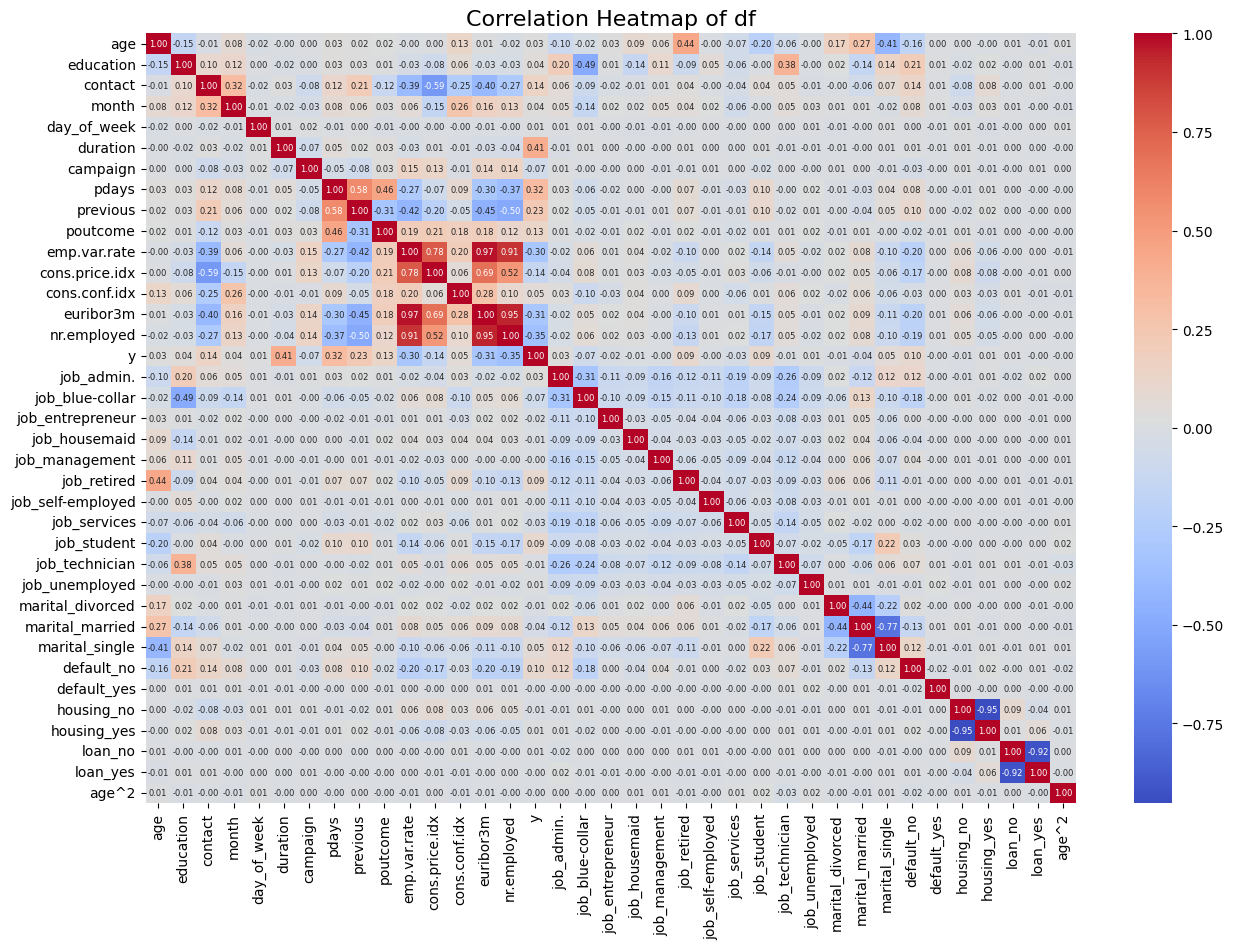

In [26]:
# Calculate the correlation coefficents
corr_mat = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation Heatmap of df', fontsize=16)
plt.show()

In [27]:
corr_mat = abs(corr_mat['y']).sort_values(ascending=False)

In [28]:
# using correlation coefficients with y to choose features for KNN
pd.DataFrame(corr_mat).reset_index(drop=False)
px.scatter(corr_mat, x=corr_mat.index, y='y', title="Feature Correlations with y")

In [29]:
# Prepare a dataframe for KNN
# For KNN, exclude emp.var.rate because it is 97% correlated with euribor3m and slightly less correlated with y than euribor3m.
# Not dropping housing or loan columns, despite strong correlations, because they contain information about people who did not answer the question (both columns 0)

df_small = df[['duration', 'nr.employed', 'pdays', 'euribor3m', 'previous', 'y']]

# Choosing 2500 rows at random - more took too long to run, less gave too few y = 1 values
df_small = df_small.sample(n=2500, random_state=42)

# normalize the data for KNN
y_small = df_small['y']
X_small = df_small.drop('y', axis=1)
X_small_norm = (X_small - X_small.mean())/X_small.std()

In [30]:
# hyperparameter tuning KNeighborsClassifier() with data limited to top 5 features correlated to y and balanced (stratified)
X_train_small_norm, X_test_small_norm, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.2, random_state=42, stratify = y_small)

X_train_stratify, X_test_stratify, y_train_stratify, y_test_stratify = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

params={'n_neighbors':np.array(range(1, len( y_test_small)))}
model_finder=GridSearchCV(estimator=KNeighborsClassifier(),
     param_grid=params,
     scoring='accuracy',
     cv=5)
model_finder.fit(X_train_small_norm, y_train_small)
est = model_finder.best_estimator_
KNeighborsClassifier(n_neighbors=est)
print('Number of neighbors: ', est)
preds = est.predict(X_test_small_norm)
score = model_finder.cv_results_['mean_test_score'].max()
print('Score: \n', score) # accuracy
# n_neighbors is 8 with either weighting method

Number of neighbors:  KNeighborsClassifier(n_neighbors=np.int64(8))
Score: 
 0.9075


In [31]:
# use values near n_neighbors=8 and try different weights
params = {'n_neighbors': range(1, 18), 'weights': ['uniform', 'distance']}
model_finder=GridSearchCV(estimator=KNeighborsClassifier(),
     param_grid=params,
     scoring='accuracy',
     cv=5)
model_finder.fit(X_train_small_norm, y_train_small)
est = model_finder.best_estimator_
KNeighborsClassifier(n_neighbors=est)
print("Best parameters:", model_finder.best_params_)
print("Best accuracy score:", model_finder.best_score_)
preds = est.predict(X_test_small_norm)
score = model_finder.cv_results_['mean_test_score'].max()

Best parameters: {'n_neighbors': 8, 'weights': 'uniform'}
Best accuracy score: 0.9075


In [32]:
y_small.value_counts()
# note that the data are not balanced

,count
y,
0,2217
1,283


<Axes: >

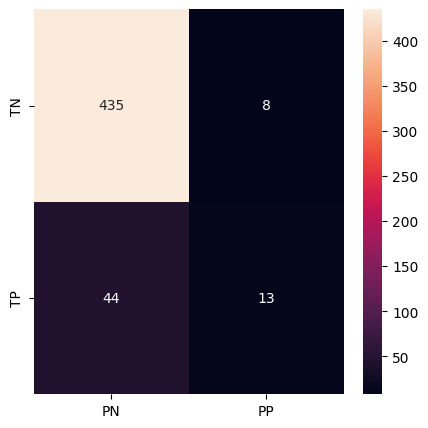

In [33]:
# confusion matrix to evaluate balance for accuracy score
cm = confusion_matrix(y_test_small, preds)
index = ['TN', 'TP']
columns = ['PN', 'PP']
cm_df = pd.DataFrame(cm, index=index, columns=columns)
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt='g')
# again, note that the data are not balanced

In [34]:
# Because True Positive and True Negative are not balanced, precision is a better metric than accuracy.
# Calculating precision instead because the data are not balanced and True Positives are what the customer needs.
# TP/TP+FP
precision = cm_df.iloc[1, 1] / (cm_df.iloc[1, 1] + cm_df.iloc[0, 1])
print('Precision: ', precision)

Precision:  0.6190476190476191


In [35]:
# LogisticRegression() - switched to same data as used for KNN
# Did not see strong reason to change the defaults

lr = LogisticRegression().fit(X_train_small_norm, y_train_small)
train_score = lr.score(X_train_small_norm, y_train_small)
test_score = lr.score(X_test_small_norm, y_test_small)
print('train score: ', train_score)
print('test score: ', test_score)

train score:  0.912
test score:  0.9


In [36]:
# hyperparameter DecisionTreeClassifier() - switched to same data as used for KNN

dt = DecisionTreeClassifier().fit(X_train_small_norm, y_train_small)
train_score = dt.score(X_train_small_norm, y_train_small)
test_score = dt.score(X_test_small_norm, y_test_small)
print('train score: ', train_score)
print('test score: ', test_score)

train score:  0.999
test score:  0.886


In [37]:
# DecisionTreeClasssifier produced better results with all the features
# Tried different hyperparameters
params = {
    'max_depth': [None, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                           param_distributions=params,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train_small_norm, y_train_small)
print("Best parameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'entropy'}
Best accuracy score: 0.9035


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from graphviz import Source

model = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=3, criterion='entropy')
model.fit(X_train_small_norm, y_train_small)
dot_data = tree.export_graphviz(model,
     rounded=True, special_characters=True,
     out_file=None)
graph = Source(dot_data)
graph.view()
# open the pdf file to see the decision tree for the top 5 features

'Source.gv.pdf'

In [39]:
# hyperparameter tuning SVC() - tuning kernel with small dataset
# Support Vector Machines - uncomment to run - takes about 10 minutes wall time

#svc = SVC().fit(X_train_small_norm, y_train_small)
#svc_defaults = svc.score(X_train_small_norm, y_train_small)
#params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
#grid = GridSearchCV(svc, param_grid=params).fit(X_train, y_train)
#grid_score = grid.score(X_test, y_test)

#best_kernel = grid.best_params_['kernel']
#print('best kernel: ', best_kernel)
#print('defaults: ', svc_defaults)
#print('best estimator score: ', grid_score)

#Output:
#best kernel:
#defaults:  0.8865
#best estimator score:  0.9027440505099563

In [40]:
# More tuning of hyperparameters can done
# With the current hyperparameters, accuracy = 0.9075 with KNN is the best score
# What the customer really needs to know is what are the characteristics of customers who are likely and not likely to open an account.
# Understandinng of the cluster feature values are needed.

##### Questions